In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 加载数据集
train_data_path = 'kaggle_house_pred_train.csv'
test_data_path = 'kaggle_house_pred_test.csv'
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# 分离特征和目标变量
X_train = train_data.drop('SalePrice', axis=1)  # 特征
y_train = train_data['SalePrice']               # 目标变量

X_test = test_data.copy()  # 测试集没有 'SalePrice' 列


# 选择数值和分类列
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# 创建预处理步骤
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# 预处理列并构建column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# 现在将预处理器应用于X_train和X_test
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# 获取输入特征的数量
input_features = X_train.shape[1]

# 定义模型
class NeuralNetwork(nn.Module):
    def __init__(self, input_features):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# 实例化模型
model = NeuralNetwork(input_features)

# 定义损失函数和优化器
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch 1/100, Loss: 0.23214686953503152
Epoch 2/100, Loss: 0.08894464956677478
Epoch 3/100, Loss: 0.05397744549681311
Epoch 4/100, Loss: 0.044196434238034744
Epoch 5/100, Loss: 0.04002380893444237
Epoch 6/100, Loss: 0.04059085083882446
Epoch 7/100, Loss: 0.035432298141329185
Epoch 8/100, Loss: 0.034608452742838344
Epoch 9/100, Loss: 0.031963885275889996
Epoch 10/100, Loss: 0.03108540294772905
Epoch 11/100, Loss: 0.02932391712523025
Epoch 12/100, Loss: 0.02814368168701944
Epoch 13/100, Loss: 0.026305337881912357
Epoch 14/100, Loss: 0.02491254865637292
Epoch 15/100, Loss: 0.023165423848220835
Epoch 16/100, Loss: 0.02161235410882079
Epoch 17/100, Loss: 0.020259933343724064
Epoch 18/100, Loss: 0.018283085573626602
Epoch 19/100, Loss: 0.016679308377206326
Epoch 20/100, Loss: 0.014519555899112122
Epoch 21/100, Loss: 0.015064661431571712
Epoch 22/100, Loss: 0.01195660879349579
Epoch 23/100, Loss: 0.0109615716981985
Epoch 24/100, Loss: 0.009985647710931042
Epoch 25/100, Loss: 0.0096223267989800

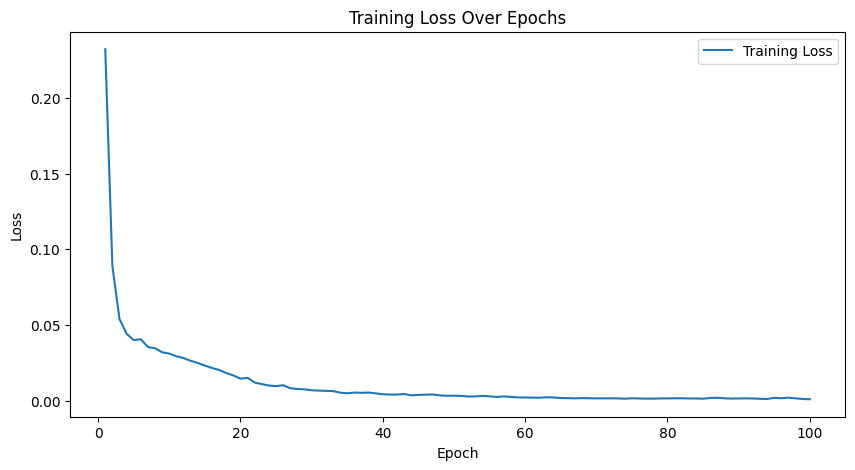

In [13]:
import numpy as np
import matplotlib.pyplot as plt
# Assuming X_train is a sparse matrix after preprocessing, we'll convert it to a dense array first
X_train_dense = X_train.toarray() if X_train.size <= 1e6 else X_train  # You can adjust the size check as needed

# Now we can convert the dense array to a PyTorch tensor
X_train_tensor = torch.tensor(X_train_dense, dtype=torch.float32)
# 假设y_train原始未归一化
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

# 转换为张量
y_train_tensor = torch.tensor(y_train_scaled.astype(np.float32)).view(-1, 1)

# 定义训练数据的DataLoader
train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)

# Lists to store training losses
train_losses = []
epochs = 100
# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        epoch_loss += loss.item()
    
    # Calculate average epoch loss
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    
    # Print the epoch loss
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}')

# Plotting the training loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()



In [31]:
# 将稀疏矩阵转换为密集数组
X_test_dense = X_test.toarray()

# 将密集数组转换为PyTorch张量
X_test_tensor = torch.tensor(X_test_dense, dtype=torch.float32)

# 从 scipy 稀疏矩阵创建 PyTorch 稀疏张量
X_test_coo = X_test.tocoo()  # 转换为 COO 格式
values = X_test_coo.data
indices = np.vstack((X_test_coo.row, X_test_coo.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = X_test_coo.shape

X_test_tensor = torch.sparse_coo_tensor(i, v, torch.Size(shape), dtype=torch.float32)


In [36]:
# 使用模型进行预测
model.eval()  # 设置为评估模式
with torch.no_grad():
    predictions = model(X_test_tensor)

# 将预测结果转换为Numpy数组
predictions = predictions.numpy().flatten()

In [39]:
import numpy as np

# 使用模型进行预测
model.eval()  # 设置为评估模式
with torch.no_grad():
    predictions = model(X_test_tensor)

# 将预测结果转换为Numpy数组
predictions = predictions.numpy().flatten()

# 假设 'scaler_y' 是你用于标准化 'SalePrice' 的那个 StandardScaler 实例
# 你需要将预测的价格进行逆变换，以转换回原始的价格范围
predicted_prices = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()

# 创建提交DataFrame
submission = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': predicted_prices
})

# 将提交数据保存到CSV文件
submission.to_csv('house_prices_submission.csv', index=False)
